# Building our database

## Objective

The main goal of this notebook is to build a database with the information we have scraped from the web. We will use the `sqlite3` library to create a database and the `pandas` library to create a dataframe with the information we have scraped.



### Methodology

Initially, we are going to get the stats of the games that we saved in the /data/scores folder, manipulate it and save it in a dataframe, storing in a SQL database. But we also have to deal with new daily incoming data. This new data comes from the /data/actual_month_scores folder. So, we are going to create a function that will be able to update the database with the new data, on a dalily basis.



In [20]:
import os 
import pandas as pd
from bs4 import BeautifulSoup
import re
from datetime import date
from tqdm import tqdm
import sqlalchemy
import pickle


    

pd.set_option('mode.chained_assignment', None)

In [21]:
#setting our directoys paths
DATA_DIR = os.path.join(os.getcwd(), 'data')
SCORE_DIR = os.path.join(DATA_DIR, 'scores')
SCORE_DIR_ACTUAL = os.path.join(DATA_DIR, 'actual_month_scores')

Defining the functions that we will run:

In [22]:
def clean_html(box_score):
    """ Info:
        This function will clean the html file and return a soup object
        ---------------------------------------------------------------
        Input:
        box_score: html file
        ---------------------------------------------------------------
        Output:
        soup: BeautifulSoup object
        """
    
    with open(box_score, 'r', encoding="utf-8", errors='ignore') as f:
        html = f.read()
    
    soup = BeautifulSoup(html)
    [f.decompose() for f in soup.select('tr.over_header')]
    [f.decompose() for f in soup.select('tr.thead')]
    print('Box score readed and parsed to soup object')

    return soup


In [23]:
def get_score_line(soup):
    """ Info:
        This function will get the score line from the soup object
        and return a dataframe with the score line.
        ---------------------------------------------------------------
        Input:
        soup: BeautifulSoup object
        ---------------------------------------------------------------
        Output:
        score_row: Dataframe with the score line of the game with total points.  """

    score_row = pd.read_html(str(soup), attrs={'id': 'line_score'})[0] # grab the first table, thats actually the table we want
    print(score_row)
    # we get to change name of first column and last column (total and teams names) because colunns dinamically change in between
    try:
        print('entering the try block for score line function')
        score_row.columns.values[0] = 'Team' # first column with the teams name
        score_row.columns.values[-1] = 'Total' # switch name of T for Total
        score_row = score_row[['Team', 'Total']] # we get only the important values for us, and ignore the partial scores.
    # if we get a key error, it means that "None of [Index(['Team', 'Total'], dtype='object')] are in the [columns]" so we need to change the name of the columns
    except KeyError:
        print('entering the except block')
        #renaming the columns, 0 is the first column and we renaming to team, 'T' is the last column and we rename to 'Total'
        score_row.rename(columns={0: 'Team', 'T': 'Total'}, inplace=True)
        score_row = score_row[['Team', 'Total']] # we get only the important values for us, and ignore the partial scores.
        print('Score line extracted under exception error')


        
     
    return score_row



In [24]:
#Now, we gonna create a function to grab the basic and advanced stats by team, in a list of the 2 teams that are playing each other
def get_stats(soup, team, stat):
    """ Info:
        This function will get the stats from the soup object
        and return a dataframe with the stats.
        ---------------------------------------------------------------
        Input:
        soup: BeautifulSoup object
        team: string with the team name
        stat: string with the type of stats (basic or advanced)
        ---------------------------------------------------------------
        Output:
        df: Dataframe with the stats of the game.  """
    
    df = pd.read_html(str(soup), attrs={'id':f'box-{team}-game-{stat}'}, index_col=0)[0] # indexcol will be the players column
    
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

In [25]:
#Function to get the season of that game.
def get_game_season(soup):
    """ Info:
        This function will get the season of the game from the soup object
        and return a string with the season.
        ---------------------------------------------------------------
        Input:
        soup: BeautifulSoup object
        ---------------------------------------------------------------
        Output:
        string: string with the season of the game.  """
    id = soup.select('#bottom_nav_container')[0]
    string= id.find_all('u')[3] # this u tag has the exact season, so we use regex to extract it
    return re.findall(r'\d{4}-\d{2}', str(string))[0]

We will have to run the following cell in order to build our initial database, which does not include the data from the current month.
This will erase any previous database that we have created.

We run this in 2 conditions:

1 - First time we run the notebook

2 - We havent run the notebook for a month or more, meaning that our past data is not up to date.



In [26]:
# #Getting the names of or downloaded boxscore in a list if it is the first time running the code

# #first, we decompress the compressed_games.zip file
# import zipfile
# import os
# with zipfile.ZipFile('data/compressed_games.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/scores')

# #then, we get the names of the files in the directory
# box_scores_old = os.listdir(SCORE_DIR)

# # joining the names of the boxscores with ther directory to a list of html files
# box_scores_old = [os.path.join(SCORE_DIR, file) for file in box_scores_old if file.endswith('.html')] # file names

# print(f'we have {len(box_scores_old)} games scraped')

# games_scores = box_scores_old



## boxscores from actual month

We are going to automactically update our database with the new data that we have scraped from the web. This will be done on a daily basis. We will have to run the following cell in order to update our database with the new data.

If we have not run the notebook for a month or more, we will have to run the cell above in order to build our initial database, which does not include the data from the current month, and we run this cell after we are done with our first sql database.

In [27]:

box_scores = os.listdir(SCORE_DIR_ACTUAL)

# joining the names of the boxscores with ther directory
box_scores = [os.path.join(SCORE_DIR_ACTUAL, file) for file in box_scores if file.endswith('.html')] # file names

print(f'we have {len(box_scores)} games scraped')


games_scores = box_scores

we have 80 games scraped


In [28]:
box_scores

['c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304010MIA.html',
 'c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304010NOP.html',
 'c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304020ATL.html',
 'c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304020BRK.html',
 'c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304020CHI.html',
 'c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304020CHO.html',
 'c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304020CLE.html',
 'c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304020DEN.html',
 'c:\\Users\\joaot\\1 notebooks\\NBA-game-outcome\\Web Scraping\\data\\actual_month_scores\\202304020HOU

we want to grab
 1 -  who win

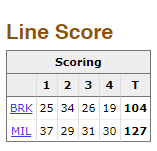
 
 Here, the home team is always in the second line.



2- basic and advanced scores

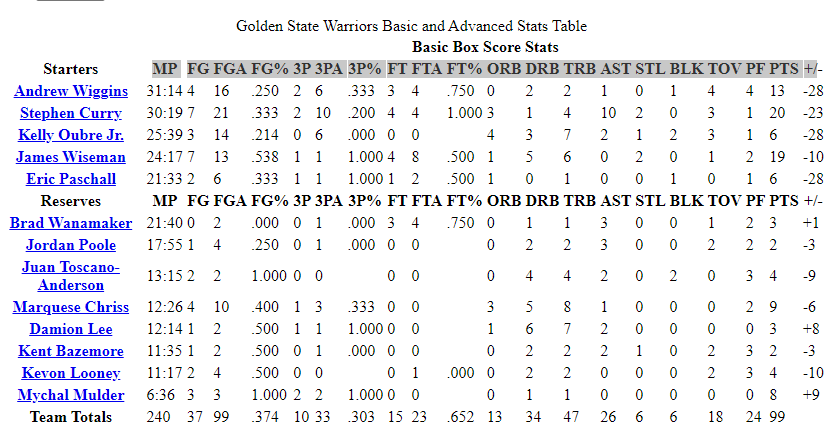

We want to remove the
'Basic Box Score Stats' table title
and the columns names that appear in the reserves section of the table



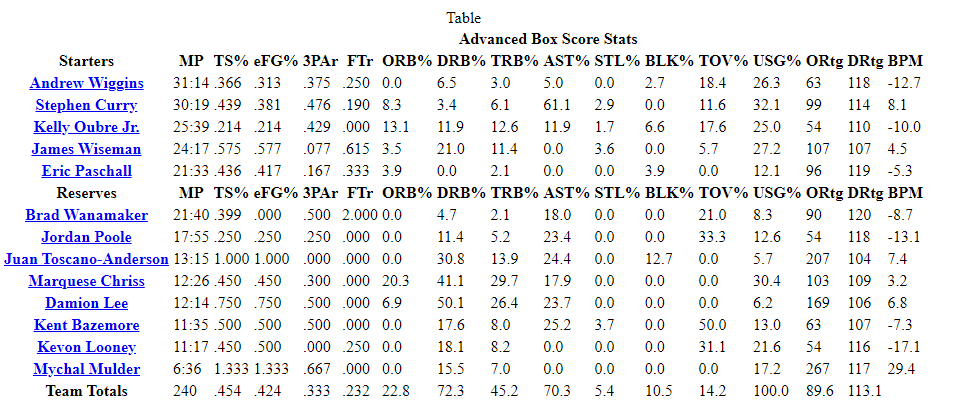

# With the get stats function, we have the tables of the basic and advanced stats.

I will now concatenate these 2 tables, and only with the content of the last line of the table, the team totals. taht gonna be the feature row per team.

Now we can approach our data in 2 different ways, to get the team stats of that match taking in account if the team is home ou away, the win ou loss target, and the opponent team stats, in a single row for that team name:

1 - The team 1 stats + CONCATENATING + the team 2 stats to get the 1 team feature in one row, and inverting to get the same for team 2

2 - The team 1 stats / the team 2 stats to get the 1 team feature in one row, and inverting to get the same for team 2




Lets first create a id to check if a game is already parsed. We gonna call it as games_ids.

In [29]:
if 'games_ids.pkl' not in os.listdir():
    games_ids = []
else:
    games_ids = pickle.load(open('games_ids.pkl', 'rb'))

In [30]:
#%pip install lxml

In [31]:
#test cell to cat playoff games possible errors
box_score = games_scores[-1]    
soup = clean_html(box_score)
score_row = get_score_line(soup)

Box score readed and parsed to soup object
  Unnamed: 0   1   2   3   4    T
0        GSW  29  32  29  33  123
1        SAC  29  26  36  35  126
entering the try block for score line function
entering the except block
Score line extracted under exception error


In [32]:
base_cols = None
games = []
count = 0 # coounting the number of corrupted html files

for box_score in tqdm(games_scores): # tqm to track progress.
    # we get the name of the file, and we check if it was already parsed
    game_file_name = os.path.basename(box_score)

    if game_file_name in games_ids: # if this data was aready grabbed of the box downloaded, go to next
        print(f'{game_file_name} already parsed!')
        continue

    
    try:  # if html is somewaht corrupted, we go to the next
        
        soup = clean_html(box_score)
        score_row = get_score_line(soup)
        
        all_stats = [] # this is resposible to store data from both teams

        for team in score_row['Team']:
            
            # we do not need the +/- and BPM columns, as they are not present in totals of the team standings
            basic_df = get_stats(soup, team, 'basic')      
            advanced_df = get_stats(soup, team, 'advanced')
            

            # we only need the totals row of the stats table, and we need to concatenated both basic and advanced table
            totals = pd.concat([basic_df.iloc[-1], advanced_df.iloc[-1]], axis=0)# concat 2 series
            totals.index = totals.index.str.lower()
            
            
            

            # getting also the coluns of te max individual stat per player, so we exclude totals. This line , maxes, is optional.
            maxes = pd.concat([basic_df.iloc[:-1].max(), advanced_df.iloc[:-1].max()], axis=0)
            maxes.index =  maxes.index.str.lower() + '_max' 

            stats = pd.concat([totals, maxes], axis=0)
            

            #some tables do not have the same rows, with a variable named bpm, and duplicates, so we gonna deal with

            if base_cols is None:
                base_cols = list(stats.index.drop_duplicates(keep='first'))
                base_cols = [col for col in base_cols if 'bpm' not in col]

            stats = stats[base_cols]

            # append for both teams

            all_stats.append(stats)

        stats = pd.concat(all_stats, axis=1).T # stacking rows of teams

        # combining the score row with stats to get the points and the name of the team
        game_stats = pd.concat([stats, score_row], axis=1) # stacking columns of dfs
        game_stats['season'] = get_game_season(soup)

        # getting just the date of the file name
        
        game_stats['date'] = pd.to_datetime(game_file_name[:8])
        
        

        game_stats['home'] = [0, 1]  # as the home team is always second in the list, we just index this way
        
        game_stats_opponent = game_stats.iloc[::-1].reset_index() # let us concatenate later
        game_stats_opponent.columns = 'opponent_' + game_stats_opponent.columns 

        

        full_game_stats = pd.concat([game_stats, game_stats_opponent], axis=1)
        full_game_stats['ID'] = game_file_name
        full_game_stats['WIN'] = full_game_stats['Total'] > full_game_stats['opponent_Total'] #adding the target column WIN (1) or LOSS (0)

        games.append(full_game_stats)
        games_ids.append(game_file_name) # appending the game unique file name

        
    except:
        count += 1
        print(f'Number of corrupted boxes: {count}')
        print(f'Corrupted box: {game_file_name}')
        continue


   

  0%|          | 0/80 [00:00<?, ?it/s]

202304010MIA.html already parsed!
202304010NOP.html already parsed!
202304020ATL.html already parsed!
202304020BRK.html already parsed!
202304020CHI.html already parsed!
202304020CHO.html already parsed!
202304020CLE.html already parsed!
202304020DEN.html already parsed!
202304020HOU.html already parsed!
202304020MIL.html already parsed!
202304020MIN.html already parsed!
202304020NYK.html already parsed!
202304020OKC.html already parsed!
202304020ORL.html already parsed!
202304020SAC.html already parsed!
202304040BRK.html already parsed!
202304040CHI.html already parsed!
202304040CHO.html already parsed!
202304040DET.html already parsed!
202304040GSW.html already parsed!
202304040HOU.html already parsed!
202304040MEM.html already parsed!
202304040NOP.html already parsed!
202304040ORL.html already parsed!
202304040PHI.html already parsed!
202304040PHO.html already parsed!
202304040UTA.html already parsed!
202304040WAS.html already parsed!
202304050ATL.html already parsed!
202304050BOS.h

 95%|█████████▌| 76/80 [00:01<00:00, 66.74it/s]

Box score readed and parsed to soup object
  Unnamed: 0   1   2   3   4    T
0        ATL  19  25  31  24   99
1        BOS  29  45  20  18  112
entering the try block for score line function
entering the except block
Score line extracted under exception error
Box score readed and parsed to soup object
  Unnamed: 0   1   2   3   4    T
0        NYK  30  20  28  23  101
1        CLE  24  21  25  27   97
entering the try block for score line function
entering the except block
Score line extracted under exception error
Box score readed and parsed to soup object
  Unnamed: 0   1   2   3   4    T
0        BRK  25  33  23  20  101
1        PHI  30  37  26  28  121
entering the try block for score line function
entering the except block
Score line extracted under exception error
Box score readed and parsed to soup object
  Unnamed: 0   1   2   3   4    T
0        GSW  29  32  29  33  123
1        SAC  29  26  36  35  126
entering the try block for score line function
entering the except block

100%|██████████| 80/80 [00:05<00:00, 14.85it/s]


In [33]:
#checking the shape of all dataframes
len(games)

5

In [34]:
#saving our parsed games in a dataframe
if games: 
    df_games = pd.concat(games, axis=0, ignore_index=True) # stack rows of games, assuming all dfs have the same columns
    print(f'{len(games)} new games added!')
else:
    print('no new games added!')

5 new games added!


In [35]:
# creating a database
engine = sqlalchemy.create_engine('sqlite:///nba_games.db', echo=False)

# reading from database
df_allgames = pd.read_sql('SELECT * FROM nba_games', con=engine)

In [36]:
#cheking the columns of df_games and df_allgames that are not the same
set(df_games.columns) - set(df_allgames.columns)




set()

In [50]:
#checking if df_games has any duplicated columns
df_games.columns.duplicated().sum()

4

In [51]:
#dropping duplicated columns from df_games
df_games = df_games.loc[:,~df_games.columns.duplicated()]

In [52]:
#trating df_games to have the same columns as df_allgames
df_games = df_games[df_allgames.columns]
df_games.shape

(10, 149)

In [49]:
df_allgames.shape

(14998, 149)

Storing new data from pandas into a SQL database

In [39]:
# creating a database
engine = sqlalchemy.create_engine('sqlite:///nba_games.db', echo=False)
# saving to database
df_games.to_sql('nba_games', con=engine, if_exists='append', index=False)
#saving games ids into a file
pickle.dump(games_ids, open('games_ids.pkl', 'wb'))
# reading from database
df_allgames = pd.read_sql('SELECT * FROM nba_games', con=engine)


In [40]:
#checking if df_all games were appended
df_allgames.tail()

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,opponent_usg%_max,opponent_ortg_max,opponent_drtg_max,opponent_Team,opponent_Total,opponent_season,opponent_date,opponent_home,ID,WIN
14993,240.0,36.0,83.0,0.434,10.0,31.0,0.323,15.0,21.0,0.714,...,39.3,191.0,113.0,NYK,101,2022-23,2023-04-15 00:00:00.000000,0,202304150CLE.html,0
14994,240.0,39.0,70.0,0.557,13.0,29.0,0.448,10.0,15.0,0.667,...,32.0,250.0,124.0,PHI,121,2022-23,2023-04-15 00:00:00.000000,1,202304150PHI.html,0
14995,240.0,42.0,89.0,0.472,21.0,43.0,0.488,16.0,16.0,1.000,...,42.6,233.0,146.0,BRK,101,2022-23,2023-04-15 00:00:00.000000,0,202304150PHI.html,1
14996,240.0,43.0,90.0,0.478,16.0,50.0,0.320,21.0,27.0,0.778,...,33.5,206.0,125.0,SAC,126,2022-23,2023-04-15 00:00:00.000000,1,202304150SAC.html,0
14997,240.0,44.0,98.0,0.449,12.0,32.0,0.375,26.0,32.0,0.813,...,39.3,192.0,127.0,GSW,123,2022-23,2023-04-15 00:00:00.000000,0,202304150SAC.html,1


In [41]:
df_allgames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14998 entries, 0 to 14997
Columns: 149 entries, mp to WIN
dtypes: float64(132), int64(6), object(11)
memory usage: 17.0+ MB


In [42]:
#deleting the extracted html files as we already saved them in a list as objects, in the past data scores directory
html_files = [file for file in os.listdir(SCORE_DIR) if file.endswith('.html')]
for file in tqdm(html_files):
    os.remove(os.path.join(SCORE_DIR, file))
print('All html past files deleted')


0it [00:00, ?it/s]

All html past files deleted


# Done! Data is ready!

#### Below, are some testing that we could do to some invividual data and see if everything is working as intended while we build our parse_data code

In [43]:
#testing
box_score = box_scores[0] # grab a unique example for testing
soup = clean_html(box_score)
score_row = get_score_line(soup)

teams = score_row['Team']


basic_df = get_stats(soup, teams[0], 'basic').drop(labels='+/-', axis=1)
advanced_df = get_stats(soup, teams[0], 'advanced').drop(labels='BPM', axis=1)




Box score readed and parsed to soup object
  Unnamed: 0   1   2   3   4    T
0        DAL  31  33  32  26  122
1        MIA  44  32  26  27  129
entering the try block for score line function
entering the except block
Score line extracted under exception error


In [44]:
score_row


,Team,Total
0,DAL,122
1,MIA,129


In [45]:
score_row

,Team,Total
0,DAL,122
1,MIA,129


In [46]:
basic_df.head(3)



,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Starters,,,,,,,,,,,,,,,,,,,
Luka Dončić,NaN,17.0,25.0,0.680,2.0,6.0,0.333,6.0,7.0,0.857,0.0,10.0,10.0,8.0,2.0,0.0,3.0,4.0,42.0
Kyrie Irving,NaN,10.0,17.0,0.588,1.0,4.0,0.250,2.0,2.0,1.000,0.0,3.0,3.0,8.0,0.0,0.0,1.0,3.0,23.0
Tim Hardaway Jr.,NaN,11.0,15.0,0.733,6.0,10.0,0.600,3.0,4.0,0.750,0.0,6.0,6.0,7.0,0.0,0.0,1.0,2.0,31.0


In [47]:
basic_df.iloc[-1]

MP     240.000
FG      47.000
FGA     77.000
FG%      0.610
3P      14.000
3PA     34.000
3P%      0.412
FT      14.000
FTA     16.000
FT%      0.875
ORB      1.000
DRB     30.000
TRB     31.000
AST     32.000
STL      3.000
BLK      2.000
TOV     14.000
PF      23.000
PTS    122.000
Name: Team Totals, dtype: float64

In [48]:
advanced_df.head(3)

,MP,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
Starters,,,,,,,,,,,,,,,
Luka Dončić,NaN,0.748,0.720,0.240,0.280,0.0,27.0,16.1,30.1,2.3,0.0,9.7,34.2,138.0,130.0
Kyrie Irving,NaN,0.643,0.618,0.235,0.118,0.0,8.5,5.1,25.3,0.0,0.0,5.3,21.7,132.0,139.0
Tim Hardaway Jr.,NaN,0.925,0.933,0.667,0.267,0.0,17.8,10.6,24.4,0.0,0.0,5.6,21.5,168.0,137.0
